# 1 - Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


In [3]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [4]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [5]:
# 2) Subsampling
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)


# this prints are just for understanding how to work with this dataset
#print("Presence and aboundance in subplot (0,0) : \n", cell_pop_M[0,0,:], '\n')
#print("Aboundances of the various species: \n", cell_pop_M.sum(axis=(0,1)), '\n')

p_i = np.count_nonzero(cell_pop_M, axis = (0,1))/200
#print("Absolute presence for each species: \n", presence, '\n')
#print("Relative presence for each species: \n", p_i, '\n')

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [6]:
def pairing_p(configs):
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs, axis = (1)).flatten()
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - S # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    return np.mean(np.power(S_pm,2))


C_0 = pairing_p(cell_pop_M.reshape(200, 299))/299


## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


### Analytical derivation of the tuned Lagrangian multipliers as functions of the constraints.

Adopting the notation to our specific model, we set $K=1$, and rename:

$x_a \rightarrow \vec{\sigma^{(a)}}, m \rightarrow S, f_r(x) \rightarrow \pi_i(\vec{\sigma}) = \sigma_i$

We start considering the following Hamiltonian:

$H(\vec{\sigma}, \vec{\lambda}) = - \sum_{i=1}^{S}\lambda_i f_i(\sigma) = - \sum_{i=1}^{S}\lambda_i \sigma_i $

Manipulating the partition function

$$Z(\vec{\lambda}) = \sum_{\{\vec{\sigma}\}} \exp\{\sum_{i=1}^S \lambda_i \sigma_i\} = \
    \sum_{\{\vec{\sigma}\}} \prod_{i=1}^S\exp\{\lambda_i \sigma_i\} = \
    \prod_{i=1}^S \sum_{\sigma_i = \pm 1} \exp\{\lambda_i \sigma_i\}  = \
    2^S \prod_{i=1}^S \cosh(\lambda_i)$$

Hence we can compute analytically the expected value for each variable $\sigma_i$ for a given value of $\vec{\lambda}$

$$ <\sigma_i>_{model(\vec{\lambda})} = \sum_{\{\vec{\sigma}\}} \sigma_i P(\vec{\sigma}/\vec{\lambda}) = \
\frac{\sum_{\sigma_i \pm 1} \sigma_i e^{\lambda_i \sigma_i}}{2 cosh(\lambda_i)} = tanh(\lambda_i) $$

Now we impose $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$ 

$m_i = tanh(\lambda_i) $

and inverting the system we find

$ \lambda_i = +\frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [7]:
m_i = 2*p_i - 1
eps = 10e-06 # a small regularization in order to avoid devergences
l_i = 0.5*np.log((1 - m_i + eps)/(1 + m_i + eps))


## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $<(S_+ - S_-)^2>_{exp} = <(\sum_{j=1}^{S}\sigma_j)^2>_{model} = C_0(\vec{\sigma})$ with coupled parameter $\lambda_0 = K/S$

To initialize the Lagrange multipliers we have two possible choices: extracting them from a gaussian distribution centered in 0 or to take the initial $\lambda_i$ as the one of the previous point and for $K'$ using a gaussian with variance that is a funtion of S. [WORK IN PROGRESS]

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = <(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)} - <(S_+ - S_-)^2>_{exp}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

In [11]:
import metropolis as M

In [32]:
# initialize the lagrangian parameters (utilizied the l_i from MaxEnt1)
l_0 = np.random.randn()
bk = np.concatenate((np.array([l_0]), l_i))

lagrange_multipliers = np.concatenate((np.array([l_0]), l_i))
#lagrange_multipliers = np.random.randn(299)
#lagrange_multipliers = l_i
print(lagrange_multipliers.shape)
# define experimental constraints
exp_constraints = np.concatenate((C_0[np.newaxis], m_i))
#exp_constraints = m_i

# define model functions
def pairing(configs):
    # Same as before
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs+1, axis = (1)).flatten()
    #print(S_present)
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - S # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    #print(S_pm)
    return np.mean(np.power(S_pm,2))

def model_m(configs):
    # assuming configs have a shape of (n, S) with S = 299 
    #print(np.count_nonzero(configs, axis = 0))
    #print(configs.shape)
    return configs.mean(axis=0)

# model_m -> (299,)?, pairing -> (1,)?

(300,)


In [13]:
#configuration = np.random.choice([+1,-1], size = 299)
#pairing(configuration)
#print(configuration)
#pairing(configuration)

In [33]:
def gradient(model_configs, exp_constraints):
    update1 = pairing(model_configs) - exp_constraints[0]
    #print(pairing(model_configs))
    #print(exp_constraints[0])
    update2 = model_m(model_configs) - exp_constraints[1:]
    
    #update2 = model_m(model_configs) - exp_constraints    
    gradient = np.concatenate((update1[np.newaxis], update2))
    return gradient

def adam(grad, m, s, beta1=0.9, beta2=0.99, e=1e-8):
    m = beta1*m+(1-beta1)*grad
    s = beta2*s+(1-beta2)*(grad**2)
    m_c = m/(1-beta1)
    s_c = s/(1-beta2)
    return m, s, (m_c/np.sqrt(s_c+e))

In [44]:
# Hyperparameters

# the learning rate
eta = 0.0001

# and the number of iterations
max_iter = 1000

In [29]:
import importlib
importlib.reload(M)

<module 'metropolis' from '/home/mango/Documenti/unipd/magistrale/complex_systems/Assigment1/metropolis.py'>

In [30]:
from tqdm import tqdm_notebook, tnrange
m, s = 0, 0
mean_sq_loss = np.zeros(max_iter) # gradient square sum
gradients =  []
for i in tnrange(max_iter):
    #instance of the class
    
    model = M.Metropolis(lagrange_multipliers, exp_constraints, S, max_acceptance = 0.1)

    configs = model.sample(1000)
    configuration = configs[-3:]
    g = gradient(configs, exp_constraints)
    m, s, update = adam(g, m, s)
    #lagrange_multipliers = lagrange_multipliers + eta*update 
    #print(lagrange_multipliers[0])
    lagrange_multipliers[0] = lagrange_multipliers[0] - eta*update[0]
    lagrange_multipliers[1:] = lagrange_multipliers[1:] - eta*update[1:]
    gradients.append(g[:])
    #print(update[0])
    #print(lagrange_multipliers[0])
    #print(g[0])
    mean_sq_loss[i] = np.power(g,2).sum()

TypeError: acceptance() takes 3 positional arguments but 4 were given

In [ ]:
plt.plot(mean_sq_loss)
plt.show()
l = np.power(lagrange_multipliers-bk,2)
plt.hist(l)
plt.show()
gradients = np.array(gradients[-100:]).flatten()
plt.hist(gradients)
plt.show()

In [ ]:
gradients[gradients<60000].shape


In [45]:
def pairing(configs):
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs+1)
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - 299 # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    return np.power(S_pm,2)


def model_m(configs):
    # assuming configs have a shape of (n, S) with S = 299
    return configs.mean(axis=0)


def compute_energy(configs, L_multipliers):
    """Computes the energy of a configuration."""
    model_pair = pairing(configs)
    #model_m_i = model_m(configs)
    model_parameters = np.concatenate((model_pair[np.newaxis], configs))
    return np.dot(model_parameters[1:], L_multipliers[1:]) + model_parameters[0]*L_multipliers[0]/299


In [46]:
lagrange_multipliers, exp_constraints

def METRO(lagrange_multipliers, M=1e4, N=100):
    configs = []
    configuration = np.random.choice([+1,-1], size = 299)
    flip_spins = np.random.randint(low = 0, high = 299, size = int(M))
    for index in flip_spins:
        new = np.copy(configuration) # !!!!!!!
        new[index] = -configuration[index] # !!!!!!!
        if acceptance(new, configuration, lagrange_multipliers):     # !!!!!
            configuration = new
            configs.append(configuration)    
    return np.array(configs[-N:])

def acceptance(new, old, lagrange_multipliers):
    """Implements Metropolis choice."""
    # regularizer?
    en1 = compute_energy(new, lagrange_multipliers)
    en2 = compute_energy(old, lagrange_multipliers)

    if  (en1-en2) < 0:
        return True
    else:
        P = np.random.random()
        if P < np.exp(-(en1-en2)):                 #in teoria no <------------------- BETA?
            return True
        else:
            return False


In [49]:
mean_sq_loss = np.zeros(max_iter) # gradient square sum
lagrange_multipliers = np.concatenate((np.array([l_0]), l_i))

for i in tnrange(max_iter):
    configs = METRO(lagrange_multipliers)
    g = gradient(configs, exp_constraints)
    m, s, update = adam(g, m, s)
    lagrange_multipliers = lagrange_multipliers - eta*update 
    #print(lagrange_multipliers[0])
    #lagrange_multipliers[0] = lagrange_multipliers[0] - eta*update[0]
    #lagrange_multipliers[1:] = lagrange_multipliers[1:] - eta*update[1:]
    #gradients.append(g[:])
    #print(update[0])
    #print(lagrange_multipliers[0])
    #print(g[0])
    mean_sq_loss[i] = np.power(g,2).sum()

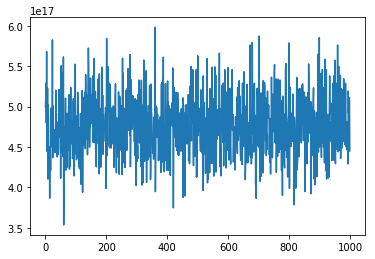

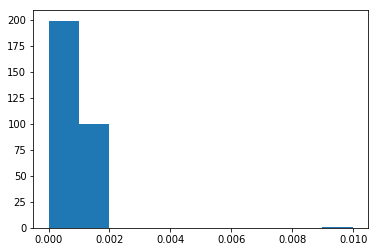

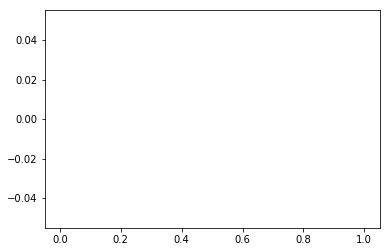

In [50]:
plt.plot(mean_sq_loss)
plt.show()
l = np.power(lagrange_multipliers-bk,2)
plt.hist(l)
plt.show()
gradients = np.array(gradients[-100:]).flatten()
plt.hist(gradients)
plt.show()

## 6 - Max Ent 3

$ H = \sum_{i=1}^S \lambda_i x_i + \frac{1}{2}\sum_{i,j=1}^S M_{ij}x_i x_j$

$M_{ij}^{-1} = Cov(x_i,x_j)_{emp}$

$\lambda_i = - \sum_{j=1}^S M_{ij}x_j$

First of all we consider the matrix X of all the aboundances for all the subplots. It is a matrix of N rows and S columns.

In [59]:
X = cell_pop_M.reshape((200,299))

Then we compute for each species the mean and the standard deviation

In [64]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)

We keep only those species that satisfy:

$<x_i>_{emp} - \sigma_{x_i} > 0$

In [66]:
aboundance_mask = x_mean - x_std > 0 
X_most_ab = X[:,aboundance_mask]

In this way we reduce the number of species from 299 to 52:

In [68]:
print(X_most_ab.shape[1])

52


Now we compute the inverse of the interaction matrix M as the covariance matrix of the abundances of the selected species and from that we obtain M inverting $M^{-1}$

In [100]:
inv_M = np.cov(X_most_ab.T)
M = np.linalg.inv(inv_M)

We now impose that the self interacting terms (diagonal) are null

In [103]:
mask = np.eye(M.shape[0]).astype('bool')
M[mask] = 0
print(M.trace())

0.0


In [104]:
print("Max interaction element: %.3f"%M.max())
print("Min interaction element: %.3f"%M.min())

Max interaction element: 0.176
Min interaction element: -0.093


At this point we can compute $\lambda_i$ with the formula reported at the begin of this section

In [250]:
X_most_mean = X_most_ab.mean(axis = 0)
lamb = -np.dot(M,X_most_mean)
#plt.hist(lamb)
#plt.show()
#plt.close()

# 7 - Analysis of the interaction network

In this first histogram we can see the distribuition of the entries of the matrix $M$. We can notice that the distribution is peaked around the zero (with a number of entries much higher than the length of the diagonal, i.e. ~600 vs 52) and it is more or less symmetric around zero.

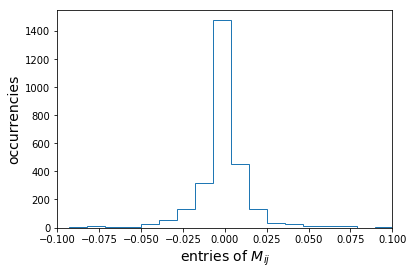

In [248]:
plt.hist(M.flatten(), bins = 25, histtype = 'step', density = False)
plt.xlim(-0.10, +0.10)
plt.xlabel("entries of $M_{ij}$", fontsize = 14)
plt.ylabel("occurrencies", fontsize = 14)

plt.show()

Now we want to put a threshold $\theta$ on the absolute value of the entries of M. We choose as range for the threshold $[0,max(abs(M))]$

In [112]:
def laplacian(A):
    degrees = A.sum(axis = 0)
    K = np.diag(degrees)
    return K-A

In [166]:
# number of threshold we want to use
T = 2000
# consider evenly spaced thresholds
thresholds = np.linspace(0, np.max(np.abs(M)), T)
# placehholder for the number of connected components for each threshold
connected_components = np.zeros(T)
# this is the order of magnitude under which we consider zero an eigenvalue
sensibility = 10**-12 
#OBS: it can't be taken too small otherwise it would count 0 connected components for theta = 0, that is absurd

for i,theta in enumerate(thresholds):
    # elementwise boolean operation, returns a matrix of True and False
    threshold_mask = np.abs(M) > theta 
    # we can compute directly the adjacency matrix from the threshold mask
    A = threshold_mask.astype(int)
    # compute the laplacian of A
    L = laplacian(A)
    # eigenvalue decomposition; "eigh" used for symmetric matrix -> default format fo eigenvalues is set to float
    eig_values,V = np.linalg.eigh(L)
    # we take as zero all the eigenvalues with absolute value under the chosen sensibility 
    almost_zero = np.abs(eig_values) < sensibility
    # number of conncected components = number of zero eigenvalues (or equivalently degeneracy of eigval 0)
    connected_components[i] = np.count_nonzero(almost_zero.astype(int))

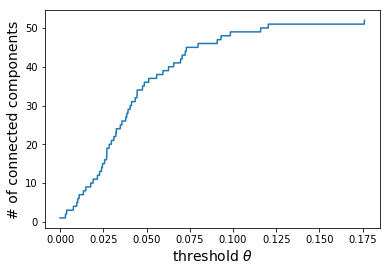

In [167]:
plt.plot(thresholds, connected_components)
plt.xlabel("threshold "+r"$\theta$", fontsize = 14)
plt.ylabel("# of connected components", fontsize = 14)
plt.show()

In [175]:
one_component_mask = connected_components == 1
theta_star = np.max(thresholds[one_component_mask])
print("Estimated theta star: %.4f"%theta_star)

Estimated theta star: 0.0031


In [168]:
# if we are interested in the detailed correspondence between threshold and connected components
for t,c in zip(thresholds, connected_components):
    print("Threshold = %.4f, connected components = %.d"%(t,c))

Threshold = 0.0000, connected components = 1
Threshold = 0.0001, connected components = 1
Threshold = 0.0002, connected components = 1
Threshold = 0.0003, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0005, connected components = 1
Threshold = 0.0006, connected components = 1
Threshold = 0.0007, connected components = 1
Threshold = 0.0008, connected components = 1
Threshold = 0.0009, connected components = 1
Threshold = 0.0010, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0012, connected components = 1
Threshold = 0.0013, connected components = 1
Threshold = 0.0014, connected components = 1
Threshold = 0.0015, connected components = 1
Threshold = 0.0016, connected components = 1
Threshold = 0.0017, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold 

Threshold = 0.1735, connected components = 51
Threshold = 0.1736, connected components = 51
Threshold = 0.1737, connected components = 51
Threshold = 0.1738, connected components = 51
Threshold = 0.1739, connected components = 51
Threshold = 0.1740, connected components = 51
Threshold = 0.1741, connected components = 51
Threshold = 0.1741, connected components = 51
Threshold = 0.1742, connected components = 51
Threshold = 0.1743, connected components = 51
Threshold = 0.1744, connected components = 51
Threshold = 0.1745, connected components = 51
Threshold = 0.1746, connected components = 51
Threshold = 0.1747, connected components = 51
Threshold = 0.1748, connected components = 51
Threshold = 0.1749, connected components = 51
Threshold = 0.1749, connected components = 51
Threshold = 0.1750, connected components = 51
Threshold = 0.1751, connected components = 51
Threshold = 0.1752, connected components = 51
Threshold = 0.1753, connected components = 51
Threshold = 0.1754, connected comp

In [178]:
import networkx as nx

In [177]:
threshold_mask = np.abs(M) > theta_star
# this is the adjacency matrix that we are going to use for our analysis
A_star = threshold_mask.astype(int)

Analyze the structural properties of W * (degree distribution, diameter, clustering, degree assortativity, betweeness centrality). In what respect, if any, the graph is different from a random ER graph?

Mean degree: 30.42
Degree standard deviation: 10.28


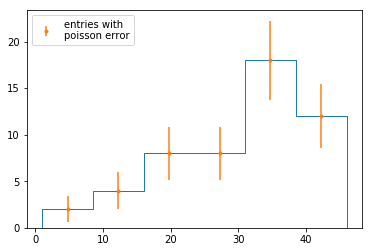

In [243]:
K = A_star.sum(axis = 0)
print("Mean degree: %.2f"% K.mean())
print("Degree standard deviation: %.2f"% K.std())
# not having much elements for a graphs we prefer to use a small amount of bins 
# in order to capture less information but more reliable
entries, bin_extremes, _ = plt.hist(K, bins = 6, histtype = 'step')
bin_centers = (bin_extremes[1:] + bin_extremes[:-1])/2
plt.errorbar(bin_centers, entries, yerr = np.sqrt(entries), fmt = '.', label = 'entries with \npoisson error')
plt.legend(loc = "upper left")
plt.show()

Using the networkx library we can easily compute most of the quantities of interest.

In [214]:
G = nx.from_numpy_matrix(A_star)

D = nx.diameter(G)
print("Diameter of the network: ", D)

# local clustering for each node
c_i_dict = nx.clustering(G)
n_nodes = len(G)
c_i = np.zeros(n_nodes)
for i in range(n_nodes):
    c_i[i] = c_i_dict[i]
    
# global clustering
C = c_i.mean()
print("Global clustering coefficient: %.2f"% C)

deg_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: %.2f"%deg_assortativity)

btw_centrality = nx.betweenness_centrality(G)
b_c = np.zeros(n_nodes)
for i in range(n_nodes):
    b_c[i] = btw_centrality[i]
print("Max beetweenness centrality: %.2f"%b_c.max())

Diameter of the network:  3
Global clustering coefficient: 0.73
Degree assortativity: -0.24
Max beetweenness centrality: 0.05


We can compare these results with the one that we would find in an Erdosh-Reny graph with the same number of nodes and with probability of connecting two nodes given by $p = \frac{<k>}{n-1}$, where $<k>$ is the observed average degree of $A^*$. To do this, we consider an ensamble of E-R graphs in order to compute the estimated quantities and not the one of a single realization.

In [228]:
p = K.mean()/(n_nodes-1)
graphs_number = 100

# we are going to store in the following arrays all the results for each single ER graph 
# and then make a statistic out of them
ER_k_std_devs = np.zeros(graphs_number)
ER_diameters = np.zeros(graphs_number)
ER_cluster_coeffs = np.zeros(graphs_number)
ER_deg_assortativities = np.zeros(graphs_number)
ER_max_btw_centralities = np.zeros(graphs_number)


for i in range(graphs_number):
    # create an Erdosh-Reny graph
    ERG = nx.gnp_random_graph(n_nodes,p)
    # compute the degree standard deviation
    degs_dict = ERG.degree()
    degs = np.zeros(n_nodes)
    for j in range(n_nodes):
        degs[j] = degs_dict[j]
    ER_k_std_devs[i] = degs.std()
    
    ER_diameters[i] =  nx.diameter(ERG)
    
    c_i_dict = nx.clustering(ERG)
    c_i = np.zeros(n_nodes)
    for j in range(n_nodes):
        c_i[j] = c_i_dict[j]

    # global clustering
    ER_cluster_coeffs[i] = c_i.mean()

    ER_deg_assortativities[i] = nx.degree_assortativity_coefficient(ERG)

    btw_centrality = nx.betweenness_centrality(ERG)
    b_c = np.zeros(n_nodes)
    for j in range(n_nodes):
        b_c[j] = btw_centrality[j]
    ER_max_btw_centralities[i] = b_c.max()

print("Degree standard deviation: %.2f"% ER_k_std_devs.mean())
print("Diameter of the network: %.2f" % ER_diameters.mean())
print("Global clustering coefficient: %.2f"% ER_cluster_coeffs.mean())
print("Degree assortativity: %.2f"%ER_deg_assortativities.mean())
print("Max beetweenness centrality: %.2f"%ER_max_btw_centralities.mean())

Degree standard deviation: 3.38
Diameter of the network: 2.00
Global clustering coefficient: 0.59
Degree assortativity: -0.04
Max beetweenness centrality: 0.01


Confronting the results of the real network with the ensamble of ER graphs:

| Quantity | Real graph | ER graph|
| --- | --- | --- |
| degree std dev | 10.28 | 3.38 |
| diameter | 3 | 2.00 |
| clustering | 0.73| 0.59 |
| assortativity | -0.24 | -0.04 |
| max centrality | 0.05 | 0.01 |

We can see that none of these quantities is too similar between the two kinds of graphs. 

More precisely we can conclude that our network:
* presents a much higher variance in the degree distribution;
* has a larger diameter (ER diameter being 2.00 for a hundred graphs imply that none of them has diameter equal 3!);
* has a higher clustering coefficient;
* has a disassortative behaviour w.r.t. the almost neutral one of the ER ensamble;
* has a central node with a betweenness centrality that is 5 times higher than the "central" node of ER graphs.

All this suggests that the network of the species has an underlying structure that is not random, but possibly depends on the "microscopic" details of each species.

NOTE: ER results could vary a bit because we don't have a fixed seed for their generator.